# Hottest Day Date
This plays around with what determines the date of the hottest day of the year in a given region.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p_water, rho_water
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn, get_heat_capacity
from isca_tools.utils import area_weight_mean_lat, area_weighting, annual_mean, annual_time_slice
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy

2023-07-06 10:02:57,653 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'swdn_toa', 'ps', 't_surf', 'olr', 'swdn_sfc', 'lwdn_sfc', 'lwup_sfc',
            'flux_t', 'flux_lhe', 'precipitation', 'vcomp', 'ucomp', 'omega']
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    p_low_level = float(ds_use.pfull[-1]) * 100     # lowest atmospheric level
    ds += [ds_use.sel(pfull=np.inf, method='nearest')]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
    mixed_layer_depth = namelist['mixed_layer_nml']['depth']

## Get datasets
Only consider one location (latitude and longitude) - see how date of hottest day varies in different years.

In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True
high_dpi = 350
low_dpi = 100

In [83]:
## Split datasets into land and ocean ones - load in summer dataset for ocean only
# Load in for a given latitude range
use_time_start = 360*2

loc = {'lat':15, 'lon': 180}

ds_all = []
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.sel(lat=loc['lat'], lon=loc['lon'], method='nearest')
        ds_all += [ds_use.load()]
        pbar.update(1)

100%|██████████| 2/2 [00:06<00:00,  3.41s/it]


## Annual Mean Seasonal Trend
This takes the annual mean, and plots the average surface and near-surface seasonal temperature cycle at the given location.

It also looks into how the winds, insolation, latent heat and relative humidity align with this temperature cycle.

In [84]:
# Take annual mean to see how temperature varies within a year on average
ds_annual_mean = [annual_mean(ds_all[i]) for i in range(n_exp)]
# Compute times corresponding to peaks in surface temperature
max_summer_time = ds_annual_mean[0].time[ds_annual_mean[0].time<8*30][
    np.argmax(ds_annual_mean[0].t_surf[ds_annual_mean[0].time<8*30].to_numpy())]
max_winter_time = ds_annual_mean[0].time[ds_annual_mean[0].time>8*30][
    np.argmax(ds_annual_mean[0].t_surf[ds_annual_mean[0].time>8*30].to_numpy())]

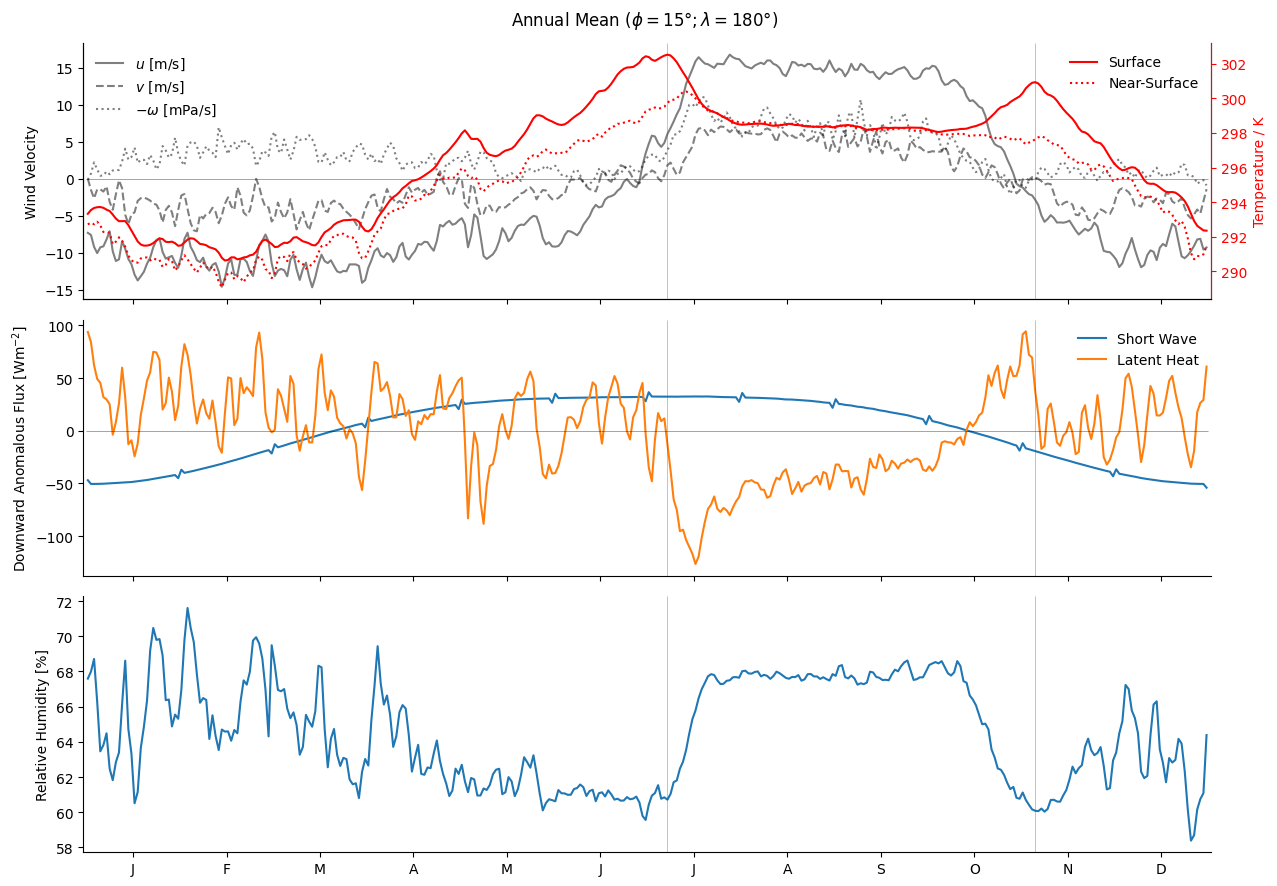

In [85]:
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])

fig, ax = plt.subplots(3,1, figsize=(13, 9), sharex=True)
ax2 = ax[0].twinx()
#ax2.set_ylim(-0.012,0.012)
ax[0].plot(ds_annual_mean[0].time, ds_annual_mean[0].ucomp, alpha=0.5, color='k', label='$u$ [m/s]')
ax[0].plot(ds_annual_mean[0].time, ds_annual_mean[0].vcomp, color='k', alpha=0.5, linestyle='--', label='$v$ [m/s]')
ax[0].plot(ds_annual_mean[0].time, -ds_annual_mean[0].omega*1000, color='k', alpha=0.5, linestyle=':', label='$-\omega$ [mPa/s]')
ax[0].hlines(0,0,360, color='k', linewidth=0.5, alpha=0.5)
ax[0].spines['top'].set_visible(False)
ax[0].set_xlim(-1,361)
# ax[0].set_ylim(-18,18)
ax[0].set_ylabel('Wind Velocity')
ax[0].legend(frameon=False)
ax[0].legend(frameon=False, loc='upper left')

ax2.spines['top'].set_visible(False)
ax2.plot(ds_annual_mean[0].time, ds_annual_mean[0].t_surf, color='r', label='Surface')
ax2.plot(ds_annual_mean[0].time, ds_annual_mean[0].temp, color='r', linestyle=':', label='Near-Surface')
ax2.tick_params(axis='y', colors='red')
ax2.spines['right'].set_color('red')
ax2.legend(frameon=False, loc='upper right')
ax2.set_ylabel('Temperature / K', color='r')

ax[1].plot(ds_annual_mean[0].time, ds_annual_mean[0].swdn_sfc-np.mean(ds_annual_mean[0].swdn_sfc), label='Short Wave')
ax[1].plot(ds_annual_mean[0].time, -(ds_annual_mean[0].flux_lhe-np.mean(ds_annual_mean[0].flux_lhe)), label='Latent Heat')
# ax[1].plot(ds_annual_mean[0].swdn_sfc - ds_annual_mean[0].flux_lhe)
ax[1].hlines(0,0,360, color='k', linewidth=0.5, alpha=0.5)
ax[1].spines[['right', 'top']].set_visible(False)
ax[1].set_ylabel('Downward Anomalous Flux [Wm$^{-2}$]')
ax[1].legend(frameon=False)

ax[2].plot(ds_annual_mean[0].time, 100*ds_annual_mean[0].sphum/sphum_sat(ds_annual_mean[0].temp,p_low_level))
ax[2].set_xticks(*month_ticks)
ax[2].spines[['right', 'top']].set_visible(False)
ax[2].set_ylabel('Relative Humidity [%]')

for ax_use in ax.flatten():
    ylim = ax_use.get_ylim()
    ax_use.vlines([max_summer_time, max_winter_time], *ylim, color='g', alpha=0.6, linewidth=0.4)
    ax_use.set_ylim(ylim)

fig.suptitle(f"Annual Mean ($\phi={loc['lat']}\degree; \lambda={loc['lon']}\degree$)")
plt.tight_layout()

## Temperature Tendency
At the surface, the temperature tendency, $\partial T/\partial t$, can be computed through the surface energy budget:
$$C\frac{\partial T}{\partial t} = F = SW^{\downarrow} + LW^{\downarrow} - LW^{\uparrow} + LH^{\downarrow} + SH^{\downarrow}$$
Where $F$ is the net flux into the surface (units of $Wm^{-2}$), and $C = c_{p, water}\rho_{water} h$ is the heat capacity of the ocean mixed layer in units of $Jkg^{-1}m^{-2}$.

The plot below confirms that the two sides of the equation match up.

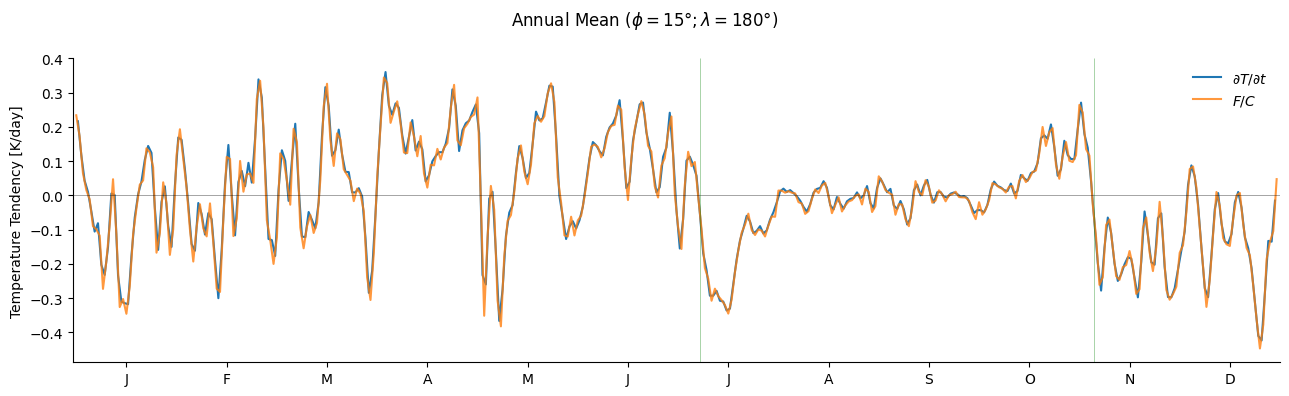

In [86]:
# Compute temperature tendency
heat_capacity = get_heat_capacity(c_p_water, rho_water, mixed_layer_depth)
net_flux_surface = ds_annual_mean[0].swdn_sfc + ds_annual_mean[0].lwdn_sfc - ds_annual_mean[0].lwup_sfc - \
                   ds_annual_mean[0].flux_lhe - ds_annual_mean[0].flux_t        # flux_lhe and flux_t defined as upward being positive
day_seconds = 24*60**2
fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.spines[['right', 'top']].set_visible(False)
ax.plot(ds_annual_mean[0].time[:-1], np.ediff1d(ds_annual_mean[0].t_surf), label='$\partial T/\partial t$')
ax.plot(ds_annual_mean[0].time-0.5, net_flux_surface/ heat_capacity * day_seconds, alpha=0.8, label='$F/C$')
ax.hlines(0,-10,370, color='k', linewidth=0.5, alpha=0.5)
ax.legend(frameon=False)
ax.set_xlim(-1,360)
ax.set_xticks(*month_ticks)
ax.set_ylabel('Temperature Tendency [K/day]')

for ax_use in [ax]:
    ylim = ax_use.get_ylim()
    ax_use.vlines([max_summer_time, max_winter_time], *ylim, color='g', alpha=0.6, linewidth=0.4)
    ax_use.set_ylim(ylim)

fig.suptitle(f"Annual Mean ($\phi={loc['lat']}\degree; \lambda={loc['lon']}\degree$)")
plt.tight_layout()

In [157]:
def sum_prev_days(var, n_days):
    """
    Assumes var wraps around i.e. when reaches the end, it wraps around to the beginning.
    Args:
        var: Variable to average over previous n_days
        n_days: Number of days to average over
    Returns:
        var_av[i] is the sum from var[i-n_days] to var_av[i]
    """
    kernel_array = np.zeros(2*n_days+1)
    kernel_array[:n_days] = 1
    return np.convolve(np.pad(var, [n_days, n_days], mode='wrap'), np.flip(kernel_array), mode='valid')

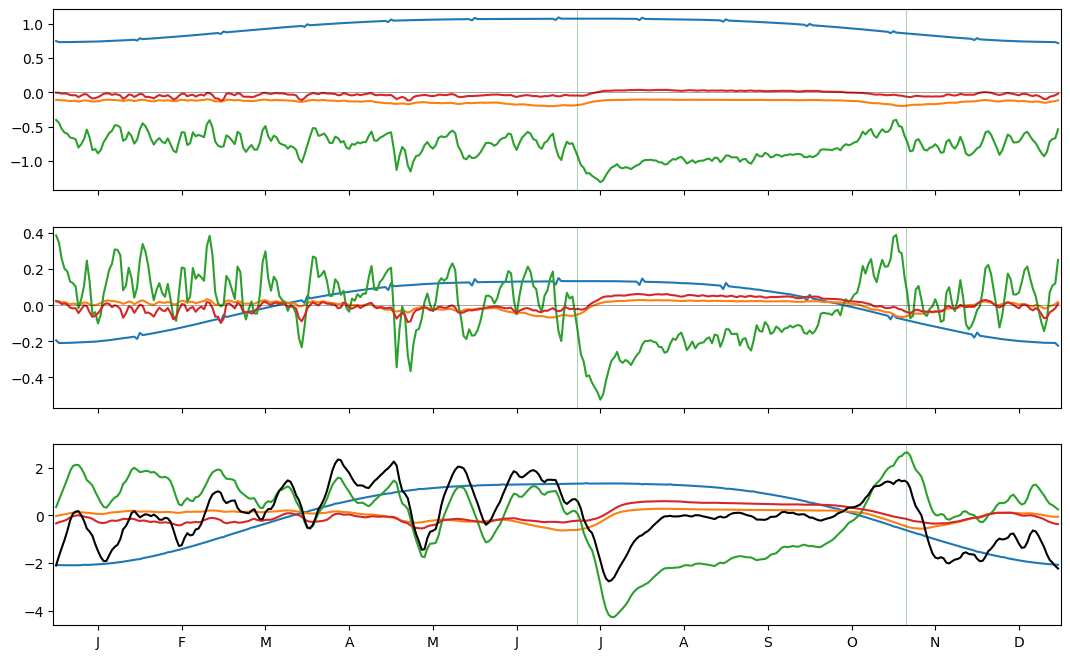

In [177]:
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(3,1, figsize=(13, 8), sharex=True)
for flux in [ds_annual_mean[0].swdn_sfc, ds_annual_mean[0].lwdn_sfc - ds_annual_mean[0].lwup_sfc, -ds_annual_mean[0].flux_lhe,
             -ds_annual_mean[0].flux_t]:
    ax[0].plot(ds_annual_mean[0].time-0.5, flux/heat_capacity * day_seconds)
    ax[1].plot(ds_annual_mean[0].time-0.5, (flux-np.mean(flux))/heat_capacity * day_seconds)
    ax[2].plot(ds_annual_mean[0].time-0.5,sum_prev_days((flux-np.mean(flux))/heat_capacity * day_seconds,10))
ax[2].plot(ds_annual_mean[0].time-0.5, sum_prev_days((net_flux_surface-np.mean(net_flux_surface))/heat_capacity * day_seconds, 10),
           color='k')
ax[0].hlines(0,-10,370, color='k', linewidth=0.5, alpha=0.5)
ax[1].hlines(0,-10,370, color='k', linewidth=0.5, alpha=0.5)
ax[0].set_xlim(-1,360)
ax[0].set_xticks(*month_ticks)
for ax_use in ax:
    ylim = ax_use.get_ylim()
    ax_use.vlines([max_summer_time, max_winter_time], *ylim, color='g', alpha=0.6, linewidth=0.4)
    ax_use.set_ylim(ylim)

In [160]:
a = sum_prev_days((flux-np.mean(flux))/heat_capacity * day_seconds,9)
len(a)

360

### Latent Heat Decomposition
I think the latent heat formula in *Isca* is linearly related to the bulk formula for evaporation:
$$E = \rho_aC_{drag}|v_a|(q^*_s - q_a)$$

According to [Frierson 2006](https://journals.ametsoc.org/view/journals/atsc/63/10/jas3753.1.xml), $v_a$, $\rho_a$ and $q_a$ are the horizontal wind, density and specific humidity evaluated at the lowest atmospheric level. $q_s^*$ is the saturation specific humidity at the surface temperature. The drag coefficient, $C_{drag}$, is calculated according to a simplified Monin–Obukhov similarity (MOS) theory.\

As the $C_{drag}$ term is quite complicated, below I see how the latent heat flux output by Isca and $|v_a|(q^*_s - q_a)$ compare.

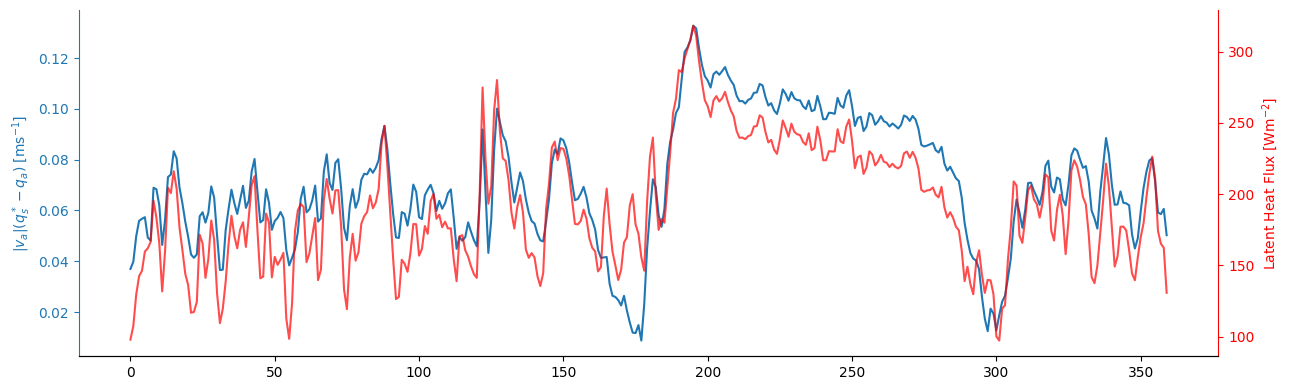

In [110]:
# omega = -ds_annual_mean[0].omega / (1.293 * 9.81)
p_surface = np.mean(ds_annual_mean[0].ps)       # surface pressure level - assume constant
wind_speed = np.sqrt(ds_annual_mean[0].vcomp**2 + ds_annual_mean[0].ucomp**2)
sphum_diff = sphum_sat(ds_annual_mean[0].t_surf, p_surface) - ds_annual_mean[0].sphum
fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.plot(wind_speed * sphum_diff, color=default_colors[0])
ax.spines[['top', 'right']].set_visible(False)
ax.spines['left'].set_color(default_colors[0])
ax.tick_params(axis='y', colors=default_colors[0])
ax.set_ylabel('$|v_a|(q^*_s - q_a)$ [ms$^{-1}$]', color=default_colors[0])
ax2 = ax.twinx()
ax2.spines[['top', 'left']].set_visible(False)
ax2.plot(ds_annual_mean[0].flux_lhe, color='r', alpha=0.7)
ax2.tick_params(axis='y', colors='r')
ax2.spines['right'].set_color('r')
ax2.set_ylabel('Latent Heat Flux [Wm$^{-2}$]', color='r')
plt.tight_layout();

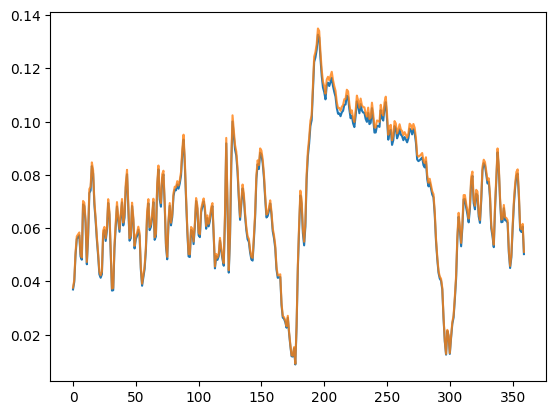

In [89]:
alpha_s = clausius_clapeyron_factor(ds_annual_mean[0].t_surf, p_surface)
q_sat_s = sphum_sat(ds_annual_mean[0].t_surf, p_surface)
r_a = ds_annual_mean[0].sphum/sphum_sat(ds_annual_mean[0].temp, p_low_level)
temp_diff = ds_annual_mean[0].temp - ds_annual_mean[0].t_surf
plt.plot(wind_speed * sphum_diff)
plt.plot(wind_speed * q_sat_s * (1 - r_a * (1+temp_diff * alpha_s)), alpha=0.8)

In [90]:
v_mean = np.mean(wind_speed)
delta_v = wind_speed - v_mean
temp_s_mean = np.mean(ds_annual_mean[0].t_surf)
delta_temp_s = ds_annual_mean[0].t_surf - temp_s_mean
temp_diff_mean = np.mean(temp_diff)
delta_temp_diff = temp_diff - temp_diff_mean
r_a_mean = np.mean(r_a)
delta_r_a = r_a - r_a_mean
q_sat_s_mean = sphum_sat(temp_s_mean, p_surface)
alpha_s_mean = clausius_clapeyron_factor(temp_s_mean, p_surface)

lh_mean = v_mean * q_sat_s_mean * (1 - r_a_mean * (1 + temp_diff_mean * alpha_s_mean))
lh_taylor_terms = {'wind': 0, 'temp_s': 0, 'r_a': 0, 'temp_diff': 0, 'temp_s_squared': 0}
lh_taylor_terms['wind'] = lh_mean/v_mean * delta_v
lh_taylor_terms['temp_s'] = v_mean * q_sat_s_mean * alpha_s_mean * (
        1 - r_a_mean - (r_a_mean * temp_diff_mean / temp_s_mean) * (alpha_s_mean * temp_s_mean - 2)) * delta_temp_s
lh_taylor_terms['r_a'] = - v_mean * q_sat_s_mean * (1+temp_diff_mean * alpha_s_mean) * delta_r_a
lh_taylor_terms['temp_diff'] = - v_mean * q_sat_s_mean * r_a_mean * alpha_s_mean * delta_temp_diff
lh_taylor_terms['wind_temp_s'] = lh_taylor_terms['temp_s']/v_mean * delta_v
lh_taylor_terms['temp_s_squared'] = v_mean * q_sat_s_mean * alpha_s_mean / temp_s_mean**2 * (
    alpha_s_mean * temp_s_mean * ((1-r_a_mean)*temp_s_mean - r_a_mean*alpha_s_mean*temp_diff_mean*temp_s_mean + 6*r_a_mean*temp_diff_mean)
    - 2*(1-r_a_mean)*temp_s_mean - 6*r_a_mean*temp_diff_mean) * 0.5 * delta_temp_s**2   # squared taylor series, need 0.5 factor

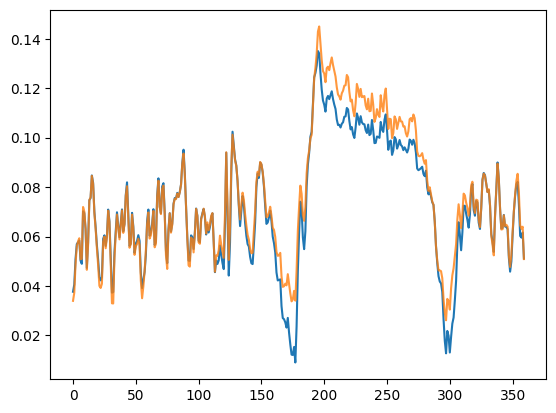

In [91]:
plt.plot(wind_speed * q_sat_s * (1 - r_a * (1+temp_diff * alpha_s)))
plt.plot(lh_mean + sum(lh_taylor_terms.values()), alpha=0.8)
# plt.plot(lh_mean + lh_taylor_terms['temp_s'] + lh_taylor_terms['wind'] + lh_taylor_terms['r_a'] + lh_taylor_terms['temp_diff'] +
#          lh_taylor_terms['temp_s_squared'] + 0*lh_taylor_terms['wind_temp_s'], alpha=0.5)


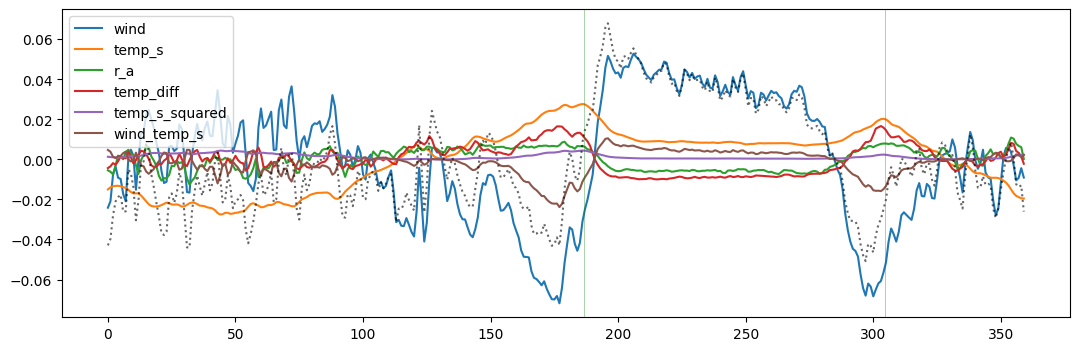

In [112]:
fig, ax = plt.subplots(1,1, figsize=(13, 4))
for key in lh_taylor_terms:
    ax.plot(lh_taylor_terms[key], label=key)
ax.plot(sum(lh_taylor_terms.values()), color='k', linestyle=':', alpha=0.6)
ax.legend()
for ax_use in [ax]:
    ylim = ax_use.get_ylim()
    ax_use.vlines([max_summer_time, max_winter_time], *ylim, color='g', alpha=0.6, linewidth=0.4)
    ax_use.set_ylim(ylim)